# Content
- [1. Load data and data description](#1)
- [2. Imputation strategy](#2)
- [3. EDA](#3")
- [4. FeatureTools](#4")
-- [4.1. Label Encoder (не стала делать)](#4.1")
-- [4.2. Feature Selection](#4.2")
- [5. Optimize with Optuna and cross validation](#5")
- [6. CatBoost](#6")
-- [6.1 CatBoost без featuretools](#6.1")
-- [6.2 CAT BOOST FEATURE TOOLS](#6.2")
-- [6.3 CAT BOOST с featuretools и отбором лучших фичей](#6.3")
- [7. H2O](#7")
- [8. Вывод](#8")

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import time

import featuretools as ft
from catboost import CatBoostClassifier
from catboost import Pool, cv

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # data visualization library

## 1. Load data and data description <a class="anchor" id="1"></a>

In [5]:
Submission_Format = pd.read_csv('/Users/ea.samoylova/ML. Advanced/Flu Data/Submission_Format.csv')
Test_Features = pd.read_csv('/Users/ea.samoylova/ML. Advanced/Flu Data/Test_Features.csv')
Training_Features = pd.read_csv('/Users/ea.samoylova/ML. Advanced/Flu Data/Training_Features.csv')
Training_Labels = pd.read_csv('/Users/ea.samoylova/ML. Advanced/Flu Data/Training_Labels.csv')

In [6]:
Training_Labels

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0
...,...,...,...
26702,26702,0,0
26703,26703,0,0
26704,26704,0,1
26705,26705,0,0


## 2. Imputation strategy <a class="anchor" id="2"></a>

In [7]:
# Отберем числовые данные
num_cols = Training_Features.select_dtypes('number').columns

# Отберем категориальные данные
cat_cols = ['race', 'sex',
            'marital_status', 'rent_or_own',  'hhs_geo_region',
            'census_msa', 'employment_industry', 'employment_occupation']

ord_cols = ['age_group', 'education',  'income_poverty',
            'employment_status']

In [8]:
#Проверим, что кол-во столбцов в категориях = количество столбцов в нащем датафрейме

assert len(num_cols)+len(cat_cols)+len(ord_cols) == Training_Features.shape[1]

In [9]:
# Для train проставим значения для пропущенных знач, в зависимости от их типа
for col in num_cols:
    Training_Features[col] = Training_Features[col].fillna(value=-1)

for col in (cat_cols+ord_cols):
    Training_Features[col] = Training_Features[col].fillna(value='missing')

# Для test тоже самое
for col in num_cols:
    Test_Features[col] = Test_Features[col].fillna(value=-1)

for col in (cat_cols+ord_cols):
    Test_Features[col] = Test_Features[col].fillna(value='missing')

## 3. EDA <a class="anchor" id="3"></a>

In [10]:
Training_Features['race'].unique()

array(['White', 'Black', 'Other or Multiple', 'Hispanic'], dtype=object)

In [11]:
Training_Features['sex'].unique()

array(['Female', 'Male'], dtype=object)

<ipython-input-177-e4f5bfc8ca82>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = Training_Features.corr()


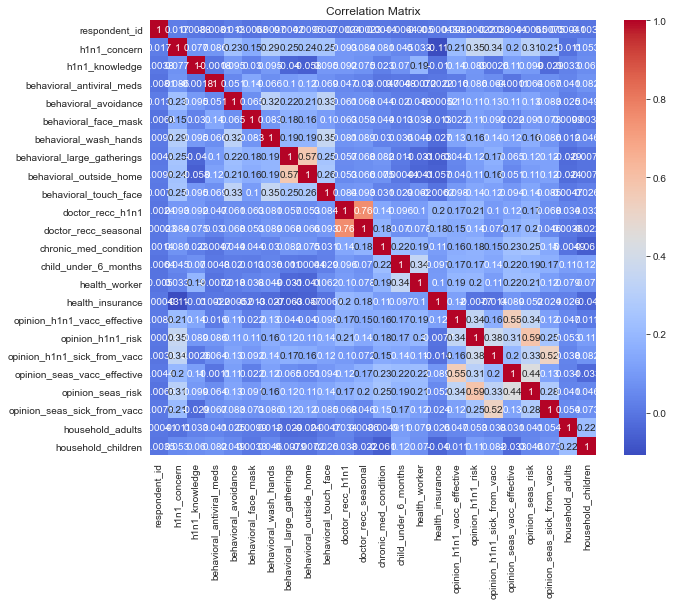

In [177]:
# Calculate the correlation matrix
corr_matrix = Training_Features.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

In [179]:
# Examine the dataset for missing values
print(Training_Features.isnull().sum())

respondent_id                  0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_re

In [181]:
# Get the summary statistics of the dataset
print(Training_Features.describe())

       respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
count   26707.000000  26707.000000    26707.000000               26707.000000   
mean    13353.000000      1.609466        1.252705                   0.046055   
std      7709.791156      0.921602        0.634498                   0.221930   
min         0.000000     -1.000000       -1.000000                  -1.000000   
25%      6676.500000      1.000000        1.000000                   0.000000   
50%     13353.000000      2.000000        1.000000                   0.000000   
75%     20029.500000      2.000000        2.000000                   0.000000   
max     26706.000000      3.000000        2.000000                   1.000000   

       behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
count          26707.000000          26707.000000           26707.000000   
mean               0.712173              0.068222               0.822743   
std                0.469646              0

## 4. Featuretools <a class="anchor" id="4"></a>

Полезные ссылки:

- https://neptune.ai/blog/feature-engineering-tools
- https://www.kaggle.com/code/kabure/houseprices-pipeline-featuretools-tpot (зачем здесь делают concat train dataset and test dataset ?)
- https://www.kaggle.com/code/mayankrakesh121/age-related-condition-tsne-feature-engineering

**Entity** - табличка датафрейм. У каждой entity должен быть столбец, который однозначно идентифицирует таблицу
**EntitySet** - большая структура данных (словарь), состоящий из множества отдельных entity
**Relationships** - отношение типа родитель - потомок, в которых для каждого родителя может быть несколько дочерних элементов.

<img src="../image/process_automl.png" alt="isolated"/>

In [12]:
es = ft.EntitySet("respondent_id")
es = es.add_dataframe(dataframe_name="NewFeatures",
                      dataframe=Training_Features,
                      index="respondent_id")

In [13]:
# Список примитивов

dfst = ft.list_primitives()
dfst[dfst.type=='transform'].name.values


array(['num_characters', 'is_in_geobox', 'second', 'cum_min', 'day',
       'exponential_weighted_std', 'rolling_max', 'square_root', 'cosine',
       'divide_numeric_scalar', 'absolute', 'not', 'add_numeric_scalar',
       'subtract_numeric', 'rolling_std', 'url_to_tld', 'is_month_start',
       'modulo_numeric', 'latitude', 'num_words',
       'greater_than_equal_to_scalar', 'haversine',
       'less_than_equal_to_scalar', 'cum_sum', 'url_to_protocol',
       'expanding_trend', 'isin', 'and', 'number_of_words_in_quotes',
       'rolling_min', 'time_since_previous', 'is_free_email_domain',
       'less_than', 'expanding_count', 'rate_of_change', 'days_in_month',
       'longitude', 'punctuation_count', 'divide_by_feature', 'diff',
       'num_unique_separators', 'is_federal_holiday', 'url_to_domain',
       'modulo_numeric_scalar', 'time_since', 'is_year_start',
       'natural_logarithm', 'cum_count', 'lag', 'minute',
       'number_of_common_words', 'expanding_max', 'is_null',
     

In [14]:
feature_matrix, features = ft.dfs(target_dataframe_name="NewFeatures",
                                  entityset=es,
                                  trans_primitives = ['add_numeric', 'multiply_numeric', 'tangent'],
                                  verbose=True)
feature_matrix.dropna(inplace=True)

Built 564 features
Elapsed: 00:00 | Progress:   0%|          

/Users/ea.samoylova/opt/anaconda3/lib/python3.8/site-packages/featuretools/synthesis/deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(


Elapsed: 00:00 | Progress:  75%|███████▍  

/Users/ea.samoylova/opt/anaconda3/lib/python3.8/site-packages/featuretools/computational_backends/feature_set_calculator.py:939: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/Users/ea.samoylova/opt/anaconda3/lib/python3.8/site-packages/featuretools/computational_backends/feature_set_calculator.py:939: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/Users/ea.samoylova/opt/anaconda3/lib/python3.8/site-packages/featuretools/computational_backends/feature_set_calculator.p

Elapsed: 00:03 | Progress: 100%|██████████


In [15]:
feature_matrix.shape

(26707, 564)

In [16]:
Training_Features.shape

(26707, 36)

In [17]:
feature_matrix.reset_index(inplace = True)

### 4.1. Label Encoder (не стала делать) <a class="anchor" id="4.1"></a>

https://habr.com/ru/articles/456294/

In [18]:
from sklearn import preprocessing

In [19]:
le = preprocessing.LabelEncoder()

In [20]:
feature_matrix['race']

0           White
1           White
2           White
3           White
4           White
           ...   
26702       White
26703       White
26704       White
26705    Hispanic
26706       White
Name: race, Length: 26707, dtype: category
Categories (4, object): ['Black', 'Hispanic', 'Other or Multiple', 'White']

In [21]:
le.fit(feature_matrix['race'])

LabelEncoder()

In [22]:
new = le.transform(feature_matrix['race'])

In [23]:
np.unique(new)

array([0, 1, 2, 3])

In [24]:
feature_matrix['race'].unique()

['White', 'Black', 'Other or Multiple', 'Hispanic']
Categories (4, object): ['Black', 'Hispanic', 'Other or Multiple', 'White']

### 4.2. Feature Selection <a class="anchor" id="4.2"></a>

In [174]:
# Отберем числовые данные
num_cols_new = feature_matrix.select_dtypes('number').columns

X = feature_matrix[[col for col in num_cols_new if col != 'respondent_id']]
y = feature_matrix['respondent_id']

kb = SelectKBest(f_classif, k=35) # configure SelectKBest

X_new = kb.fit_transform(X, y)
df_new = pd.DataFrame(X_new)

kb.fit(X, y)  # fit it to your data

/Users/ea.samoylova/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
/Users/ea.samoylova/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)


SelectKBest(k=35)

In [175]:
best_features = X.columns[kb.get_support()]
print(best_features)

best_features = best_features.insert(0, 'respondent_id')

best_features = best_features.insert(0, cat_cols)

feature_matrix_with_best = feature_matrix[best_features]

Index(['opinion_h1n1_risk * opinion_seas_sick_from_vacc',
       'opinion_h1n1_risk * opinion_seas_vacc_effective',
       'opinion_h1n1_sick_from_vacc * opinion_h1n1_vacc_effective',
       'opinion_h1n1_sick_from_vacc * opinion_seas_risk',
       'opinion_h1n1_sick_from_vacc * opinion_seas_sick_from_vacc',
       'opinion_h1n1_sick_from_vacc * opinion_seas_vacc_effective',
       'opinion_h1n1_vacc_effective * opinion_seas_risk',
       'opinion_h1n1_vacc_effective * opinion_seas_sick_from_vacc',
       'opinion_h1n1_vacc_effective * opinion_seas_vacc_effective',
       'opinion_seas_risk * opinion_seas_sick_from_vacc',
       'opinion_seas_risk * opinion_seas_vacc_effective',
       'opinion_seas_sick_from_vacc * opinion_seas_vacc_effective',
       'TANGENT(behavioral_antiviral_meds)', 'TANGENT(behavioral_avoidance)',
       'TANGENT(behavioral_face_mask)', 'TANGENT(behavioral_large_gatherings)',
       'TANGENT(behavioral_outside_home)', 'TANGENT(behavioral_touch_face)',
       'T

<ipython-input-176-b14736b7fb1f>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(feature_matrix_with_best.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)


<AxesSubplot:>

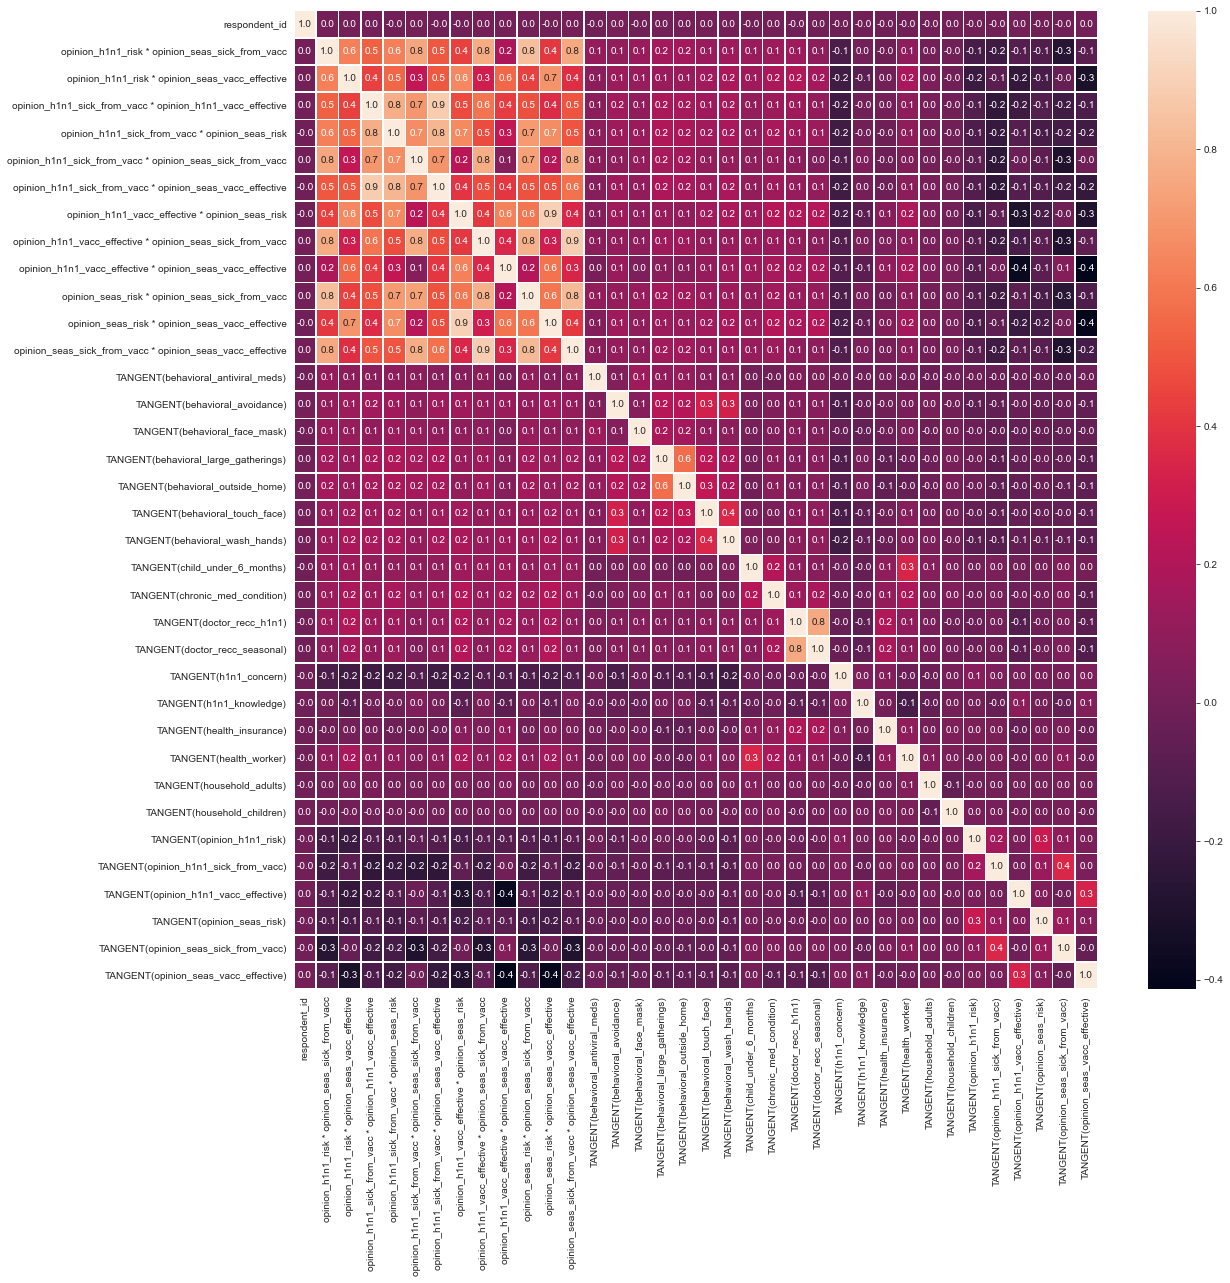

In [176]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(feature_matrix_with_best.corr(), annot=True, linewidths=.5, fmt= '.1f', ax=ax)

## 5. Optimize with Optuna and cross validation <a class="anchor" id="5"></a>

In [9]:
train_dataset = Pool(data=X_train,
                     label=y_train.h1n1_vaccine,
                     cat_features = categorical_features_indices)

/Users/ea.samoylova/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [10]:
def objective(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
    }

    scores = cv(train_dataset,
                param,
                fold_count=5,
                early_stopping_rounds=10,
                plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

In [11]:
#Очень долго будет выполняться
# sampler = optuna.samplers.TPESampler(seed=68)  # Make the sampler behave in a deterministic way.
# study = optuna.create_study(direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=100)

In [12]:
# print("Number of finished trials: {}".format(len(study.trials)))
# print("Best trial:")
# trial = study.best_trial
# print("Value: {}".format(trial.value))
# print("Params: ")
# for key, value in trial.params.items():
#     print("{}={},".format(key, value))

In [162]:
# Тут лучшие параметры, которые отдала модель
best_param = {'iterations' : 500,
'learning_rate' : 0.05745075659543725,
'random_strength' : 4,
'bagging_temperature' : 8,
'max_bin' : 5,
'grow_policy' : 'Lossguide',
'min_data_in_leaf' : 7,
'max_depth' : 6,
'l2_leaf_reg' : 11.323094517862078,
'one_hot_max_size' : 10,
'auto_class_weights' : 'Balanced'}

## 6. CatBoost <a class="anchor" id="6"></a>

### 6.1 CatBoost без featuretools <a class="anchor" id="6.1"></a>

<ipython-input-200-150b34be096a>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
/Users/ea.samoylova/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


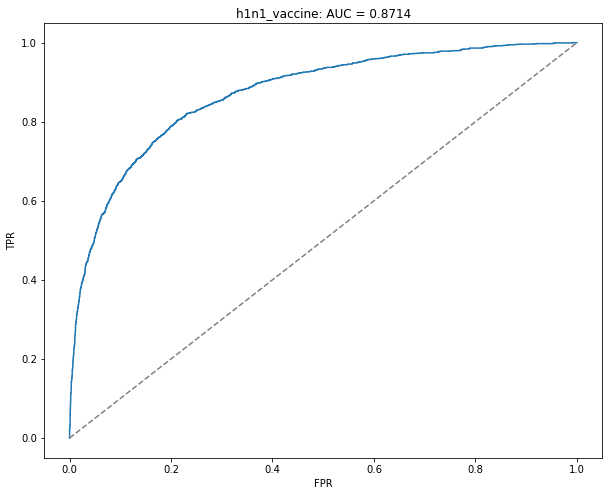

In [200]:
X_train, X_test, y_train, y_test = train_test_split(Training_Features, Training_Labels, test_size=0.3, random_state=68)

final_model = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices, **best_param)

categorical_features_indices = np.where(X_train.dtypes != np.float)[0]

final_model.fit(X_train, y_train.h1n1_vaccine)

predictions_h1 = final_model.predict_proba(X_test)

predictions_h1 = predictions_h1[:,1].reshape(-1,1)

def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['h1n1_vaccine'],
    predictions_h1,
    'h1n1_vaccine',
    ax=ax
)

In [201]:
roc_auc_score(y_test.h1n1_vaccine, predictions_h1)

0.8713860233451571

### 6.2 CAT BOOST FEATURE TOOLS  <a class="anchor" id="6.2"></a>

<ipython-input-198-3bb2aa58b243>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features_indices = np.where(X_train.dtypes != np.float)[0]


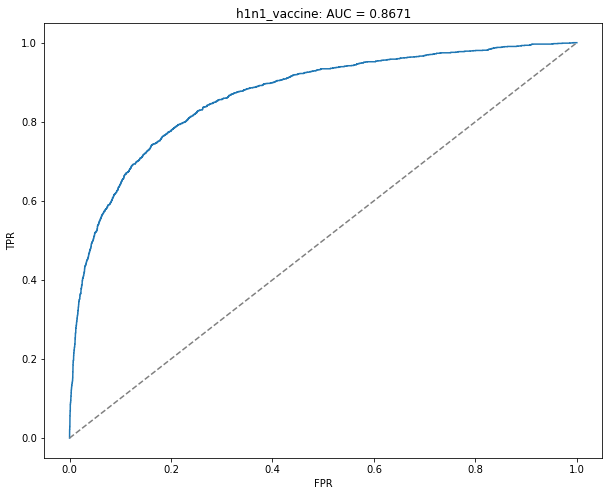

In [198]:
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, Training_Labels, test_size=0.3, random_state=68)

categorical_features_indices = np.where(X_train.dtypes != np.float)[0]

final_model = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices, **best_param)

final_model.fit(X_train, y_train.h1n1_vaccine)

predictions_h1 = final_model.predict_proba(X_test)

predictions_h1 = predictions_h1[:,1].reshape(-1,1)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['h1n1_vaccine'],
    predictions_h1,
    'h1n1_vaccine',
    ax=ax
)

In [199]:
roc_auc_score(y_test.h1n1_vaccine, predictions_h1)

0.8671152973875085

### 6.3 CAT BOOST с featuretools и отбором лучших фичей <a class="anchor" id="6.3"></a>

/Users/ea.samoylova/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


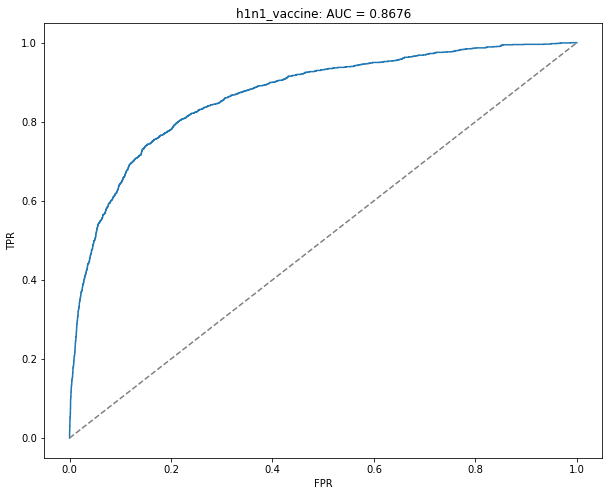

In [193]:
# Разбиваем на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(feature_matrix_with_best, Training_Labels, test_size=0.3,
                                                    random_state=68)

final_model = CatBoostClassifier(verbose=False,  cat_features=cat_cols, **best_param)

final_model.fit(X_train, y_train.h1n1_vaccine)

predictions_h1 = final_model.predict_proba(X_test)

predictions_h1 = predictions_h1[:,1].reshape(-1,1)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['h1n1_vaccine'],
    predictions_h1,
    'h1n1_vaccine',
    ax=ax
)

In [194]:
roc_auc_score(y_test.h1n1_vaccine, predictions_h1)

0.8676459203847543

## 7. H2O <a class="anchor" id="7"></a>

In [75]:
# pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [81]:
import h2o
h2o.init()

from h2o.automl import H2OAutoML

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,10 days 13 hours 8 mins
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,3 months
H2O_cluster_name:,H2O_from_python_ea_samoylova_p727xx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.998 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


https://www.kaggle.com/code/scodepy/automl-gbm-uptuna-feature-imputation

In [143]:
# Разбиваем на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(feature_matrix_with_best, Training_Labels, test_size=0.3,
                                                    random_state=68)

# Создаем фреймы для h2o

h2o_train = h2o.H2OFrame(pd.concat([X_train, y_train.h1n1_vaccine], axis=1))
h2o_test = h2o.H2OFrame(X_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [166]:
# define Gradient Boosting model
fit_1 = H2OGradientBoostingEstimator(ntrees = 100,
                                     max_depth=6,
                                     min_rows=10,
                                     learn_rate=0.05745075659543725, # default: 0.1
                                     sample_rate=1,
                                     col_sample_rate=0.7,
                                     nfolds=5,
                                     score_each_iteration=True,
                                     stopping_metric='auto',
                                     stopping_rounds=10,
                                     seed=999)


In [168]:
t1 = time.time()
fit_1.train(x=list(X_train.columns),
            y='h1n1_vaccine',
            training_frame=h2o_train)
t2 = time.time()
print('Elapsed time [s]: ', np.round(t2-t1,2))

gbm Model Build progress: |

/Users/ea.samoylova/opt/anaconda3/lib/python3.8/site-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Elapsed time [s]:  51.98


In [169]:
pred = fit_1.predict(h2o_train['h1n1_vaccine'])

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/ea.samoylova/opt/anaconda3/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset is missing column 'race': substituting in a column of NaN
  warnings.warn(w)
/Users/ea.samoylova/opt/anaconda3/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset is missing column 'sex': substituting in a column of NaN
  warnings.warn(w)
/Users/ea.samoylova/opt/anaconda3/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset is missing column 'marital_status': substituting in a column of NaN
  warnings.warn(w)
/Users/ea.samoylova/opt/anaconda3/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset is missing column 'rent_or_own': substituting in a column of NaN
  warnings.warn(w)
/Users/ea.samoylova/opt/anaconda3/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset is missing column 'hhs_geo_region': substituting in a column of NaN
  warnings.warn(w)
/Users/ea.samoylova

In [170]:
y_pred_automl = fit_1.predict(h2o_test).as_data_frame()['predict'].values

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [171]:
roc_auc_score(y_test.h1n1_vaccine, y_pred_automl)

0.855090175845906

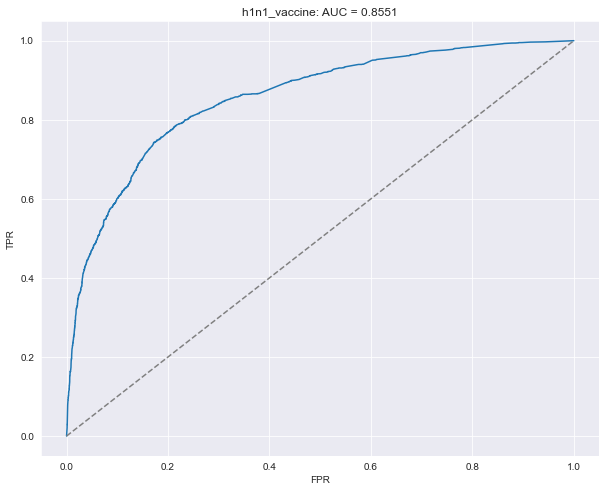

In [173]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['h1n1_vaccine'],
    y_pred_automl,
    'h1n1_vaccine',
    ax=ax
)

## 8. Вывод <a class="anchor" id="8"></a>

AUC для AutoML 0.8551
AUC для CatBoost с featuretools и feature selection 0.8676
AUC для CatBoost с featuretools 0.8671
AUC для CatBoost c optuna 0.8713

Чтобы улучшить нашу модель в AutoML необходимо еще отобрать лучшие параметры, но даже так, мы получили достаточно высокий AUC.
